In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def get_chi_square(size, df, mean_equals_one=False):
    if mean_equals_one == True:
        chi = np.random.chisquare(df=df, size=size) 
        return chi / chi.mean()
    else:
        return np.random.chisquare(df=df, size=size)

class Agent:
    def __init__(self, R, I, P, total_R, ND):
        self.R = R # R_i (ego i's own resources)
        self.I = I # I_ti (ego i's level of interest in collective goods at t iteration)
        self.P = P # P_i (ego i's power/centrality)
        self.total_R = total_R
        self.ND = ND # product of total population and network density (for formula 13)

        self.B = 0 # B_ti (share of collective goods good to ego i at t iteration) 
        self.C = 0 # C_ti (ego i's contribution at t iteration)
        self.V = False # V_ti (ego i's decision to participate at t iteration)
        self.S = 0 # S_ti (ego i's net benefit at t iteration)

        #######################################################
        self.t = 0
        #######################################################

    def set_neighbors(self, neighbors, neighbors_P_sum):
        self.neighbors = neighbors # neighbors's 
        self.neighbors_P_sum = neighbors_P_sum # total power of neighbors

    def _get_production_level(self, pi):
        return 1 / (1 + np.exp(10*(.5-pi)))

    def set_share_of_public_good(self, YR):
        ''' YR = total volume of public goods = Y_t * R_total'''
        self.B = YR * self.I # formula 2

    def set_contribution(self):
        self.C = self.R * self.V # formula 3

    def set_net_benifit(self):
        self.S = self.B - self.C # formula 4

    def get_P_ij(self, j):
        P_i = self.P
        P_j = j.P
        P_k_sum = j.neighbors_P_sum - P_i
        return ((P_i / (P_i + P_j)) * (P_i/(P_k_sum))) ** 0.5 # formula 6

    def get_net_pi(self):
        pi_defection = sum([ag_j.R * ag_j.V for ag_j in self.neighbors]) / self.total_R # pi_ti(v_ti = 0) formula 5
        pi_participation = (pi_defection + self.R + sum([self.get_P_ij(ag_j)*ag_j.R*(1-ag_j.V) for ag_j in self.neighbors])) / self.total_R # pi_ti(v_ti = 1) formula 7
        #######################################################
        # self.t += .005
        # pi_participation = (pi_defection + self.R + sum([ag_j.R*(1-ag_j.V) + self.t for ag_j in self.neighbors])) / self.total_R
        #######################################################
        return (pi_defection, pi_participation)

    def make_decision(self, YR):
        self.set_share_of_public_good(YR)
        self.set_contribution()
        self.set_net_benifit()

        pi_defection, pi_participation = self.get_net_pi()
        expect_defection = self._get_production_level(pi_defection)*self.total_R*self.I # ego i's expected net payoff upon defection
        expect_participation = self._get_production_level(pi_participation)*self.total_R*self.I - self.R
        #######################################################
        # expect_participation = self._get_production_level(pi_participation)*self.total_R*self.I 
        # expect_participation += 3
        #######################################################

        M = (expect_participation - expect_defection) / self.R # M_ti (expected marginal benefit): formula 9
        prob = 1 / (1 + np.exp(10*(1-M))) # formula 8
        #######################################################
        # self.t += 1
        # prob += (t**2) * 0.0001
        # prob = .85
        # prob = min(1, prob)
        #######################################################
        self.V = random.choices([True, False], weights=[prob, 1-prob], k=1)[0]

    def make_influence(self):
        resourse_left = self.R
        if self.V == False: # i chooses to defect
            # upward influence
            others_list = [ag_j for ag_j in self.neighbors if ag_j.V and self.I < ag_j.I]
            others_list = sorted(others_list, key=lambda ag_j: ag_j.R*(self.P/(ag_j.P)), reverse=True)
            for ag_j in others_list:
                self.I += (ag_j.I - self.I) * ag_j.get_P_ij(self) # UP1{I_ti}: formula 10
                resourse_left -= ag_j.P / (self.P * self.ND) # K_ij = formula 13
                # print(self.I, (ag_j.I - self.I) * ag_j.get_P_ij(self), ag_j.P / (self.P * self.ND))
                if resourse_left <= 0:
                    break
            # print("-"*10)

        else: # i chooses to participate
            # downward influence
            others_list = [ag_j for ag_j in self.neighbors if not ag_j.V and self.I > ag_j.I]
            for ag_j in others_list:
                self.I += (ag_j.I - self.I) * ag_j.get_P_ij(self) # DOWN{I_ti}: formula 11

            # mutal reinforcement among activists
            others_list = [ag_j for ag_j in self.neighbors if ag_j.V]
            for ag_j in others_list:
                self.I += ((self.I**2 + ag_j.I**2)**0.5 - self.I) * ag_j.get_P_ij(self) # UP2{I_ti}: formula 12

        #######################################################
        # self.I += 1
        #######################################################
        self.I = min(self.I, 100) # upper limit of I is 100

class Lattice:
    def __init__(self, N, P_df, R_df, I_df, regimes_type, density=0.1):
        self.agent_num = N
        self.density = density
        self.regimes_type = regimes_type
        if regimes_type == "Privileged":
            self.r_PR, self.r_PI = 1, 1
        elif regimes_type == "Rebellious":
            self.r_PR, self.r_PI = -1, 1
        elif regimes_type == "Impoverished":
            self.r_PR, self.r_PI = 1, -1
        elif regimes_type == "Estranged":
            self.r_PR, self.r_PI = -1, -1
        else:
            print("Regimes type is wrong!")

        self.G = bulid_network(N, density)

        # P: power/centrality
        P = list(nx.eigenvector_centrality(self.G).values())
        # P = get_chi_square(size=N, df=P_df)
        
        ALPHA = .001

        # R: resource
        while True:
            R = get_chi_square(size=N, df=R_df, mean_equals_one=True)
            #######################################################
            # R = get_chi_square(size=N, df=R_df, mean_equals_one=False)
            #######################################################
            r, p_value = pearsonr(P, R)
            if self.r_PR * r > 0 and p_value < ALPHA:
                # print("Success | r_RP = {:5f}; p-value={:3f}".format(r, p_value))
                break
        self.total_R = sum(R)

        # I: interest
        while True:
            I = get_chi_square(size=N, df=I_df, mean_equals_one=True)
            #######################################################
            # I = get_chi_square(size=N, df=I_df, mean_equals_one=False)
            #######################################################
            r, p_value = pearsonr(P, I)
            if self.r_PI * r > 0 and p_value < ALPHA:
                # print("Success | r_IP = {:5f}; p-value={:3f}".format(r, p_value))
                break

        # bulid agents
        self.agents = []
        for i in range(N):
            self.agents.append(Agent(R[i], I[i], P[i], self.total_R, N*density))

        # add neighbors to agents
        for i in range(N):
            neighbors = [self.agents[n] for n in list(self.G.neighbors(i))]
            neighbors_P_sum = sum([ag_j.P for ag_j in neighbors])
            self.agents[i].set_neighbors(neighbors, neighbors_P_sum)

    def simulate_iter(self):
        sequence = list(range(self.agent_num))
        random.shuffle(sequence)
        for i in sequence:
            YR = self.get_production_level() * self.total_R
            self.agents[i].make_decision(YR)

        for i in sequence:
            self.agents[i].make_influence()

    def get_production_level(self): 
        pi = self.get_total_contribution_rate()
        return 1/(1+np.exp(10*(.5-pi))) # Y_t (production level at the t iteration) : formula 1

    def get_total_contribution_rate(self):
        return sum([ag.C for ag in self.agents]) / self.total_R # pi_t (ratio of total contributions to total resoures) 

    def get_total_contributions(self):
        return sum([ag.C for ag in self.agents])

    def get_average_interest(self):
        return sum([ag.I for ag in self.agents]) / 100

def bulid_network(N, density, k = 20, across_ratio=.3):
    edge_n = int(density * N * (N-1) / 2) # undirected 
    within_edge_n = int(edge_n * across_ratio)
    between_edge_n = edge_n - within_edge_n
    
    within_group, between_group = [], []
    for i in range(N):
        for j in range(N):
            if j > i:
                i_group_index, j_group_index = int(i/k), int(j/k)
                if i_group_index == j_group_index:
                    within_group.append((i, j))
                else:
                    between_group.append((i, j))
    
    edges = random.sample(within_group, k=within_edge_n) + random.sample(between_group, k=between_edge_n)
    G = nx.Graph()
    G.add_nodes_from(range(0, N))
    G.add_edges_from(edges)
    # print(G.number_of_nodes(), G.number_of_edges(), nx.density(G))
    return G

# Figure 1.

/var/folders/_q/7nm19znd7d11rzql9lg9pqcw0000gn/T/ipykernel_87217/4144249100.py:77: RuntimeWarning: overflow encountered in exp
  prob = 1 / (1 + np.exp(10*(1-M))) # formula 8


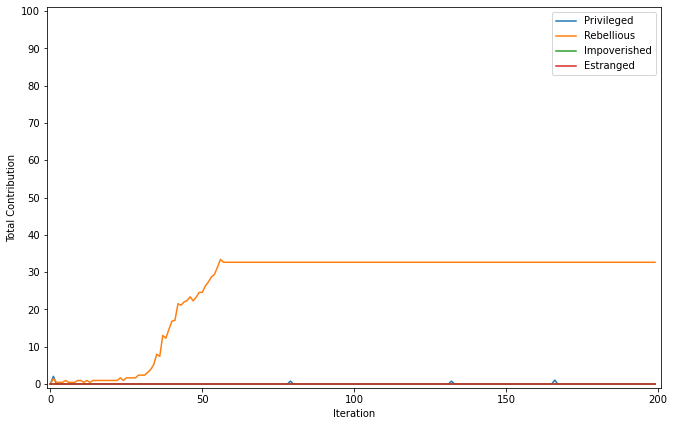

In [2]:
# R: 54, All: 3
s = 3
random.seed(s)
np.random.seed(s)

round_num = 200
log_C, log_I = [], []          

net_types = ["Privileged", "Rebellious", "Impoverished",  "Estranged"]
# net_types = ["Privileged"]
for net in net_types:
    myLattice = Lattice(100, 3, 20, 3, net) 

    c, i = [net], [net]
    for t in range(round_num):
        myLattice.simulate_iter()
        c.append(myLattice.get_total_contributions())
        i.append(myLattice.get_average_interest())

    log_C.append(c)
    log_I.append(i)

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
for i in range(len(log_C)):
    ax.plot(log_C[i][1:], label = log_C[i][0])
            
ax.set_ylim(-1, 101)
ax.set_xlim(-1, 201)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_xticks(np.arange(0, 201, 50))
fig
plt.xlabel('Iteration')
plt.ylabel('Total Contribution')
plt.legend()     
plt.savefig('F1-a')                            
plt.show()

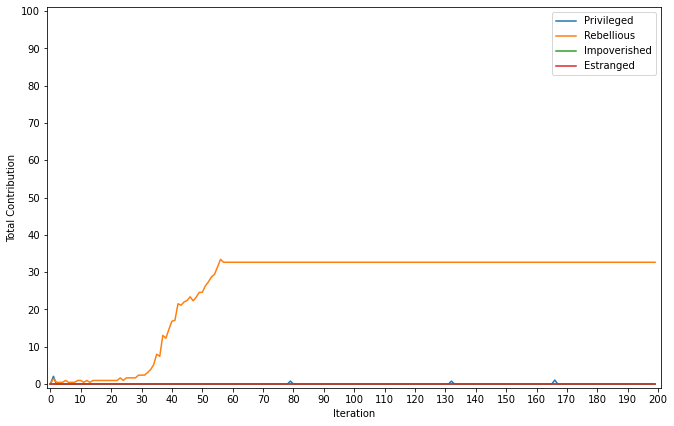

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
for i in range(len(log_C)):
    ax.plot(log_C[i][1:], label = log_C[i][0])
            
ax.set_ylim(-1, 101)
ax.set_xlim(-1, 201)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_xticks(np.arange(0, 201, 10))
plt.xlabel('Iteration')
plt.ylabel('Total Contribution')
plt.legend()     
plt.savefig('F1-a')                            
plt.show()

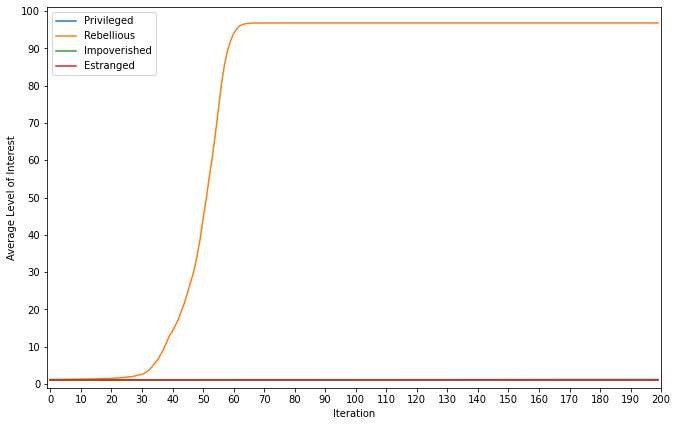

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
for i in range(len(log_I)):
    ax.plot(log_I[i][1:], label = log_I[i][0])
            
ax.set_ylim(-1, 101)
ax.set_xlim(-1, 200)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_xticks(np.arange(0, 201, 10))
plt.xlabel('Iteration')
plt.ylabel('Average Level of Interest')
plt.legend()  
plt.savefig('F1-b')                               
plt.show()

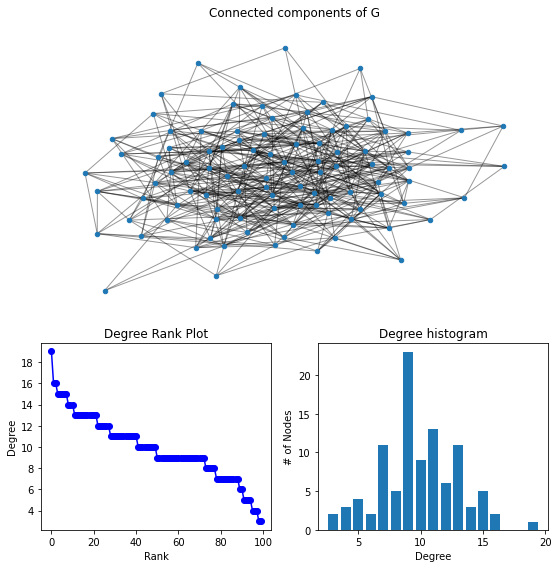

In [5]:
G = myLattice.G

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

- 峻瑋跟原文有出路的地方：
    1. P_k 是「鄰居j」所有鄰居的 power 總和，不是「自己」所有鄰居的 power 總和。
    2. UP1{I_ti} 那是針對本身選擇 defect 的人 (eq.10 is for V_ti = 0)。
    3. Influence 是「自己」(i) interest 的增加，不是鄰居 (j) 的增加。
    4. 只有 upward influence 才有「資源消耗」的問題。
    5. Network should be undirected。
- 疑問：
    1. Buliding network structure: (1) degree = 0.1 (2) N = 100, K = 20, # of group = 5 (3) 30% ties are across groups (4) ties are distributed following chi-sqaure distribution with specified degree of freedom (5) eigenvector centrality ollowing chi-sqaure distribution with specified degree of freedom -> 要如何全部滿足這五個條件？目前只能滿足前三個條件
    2. 如何指定 Power/centrality 的 df 而產生網絡？ -> 可能讓 across group tie 只連結到該組 high degree 的 nodes，讓分佈更異質。
    3. 不確定 regimes 產生的方式正不正確。

- 診斷：
    - I 起不來 -> 問題可能出現在 make Influnce 階段
    - 就算 I 起來，C 的提升卻還不完整（原圖兩者是相對應的）-> 問題是不是全部人的 V 的機率都提升，因為可能出現（1）probability 計算（2）網絡結構
    1. I & C 數值起不來：C 如果起來 I 就可以起來 -> 跟原文一樣。
    2. C 起不來是因為成為 V 的機率太低。 